In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import json
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score
from collections import defaultdict
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import sys
sys.path.append('../')
from model.baselines import CreateBaselines
from src.funcs import find_optimal_cutoff
from src.visualizations import corr_pval, interpret_corr, circos_cmap2legend, create_circos, prepare_circos_data

datasource_dir = '../data/'
datadest_dir = '../data/seed_training/'
output_dir = '../output/'

# Load data

In [2]:
train = pd.read_csv(datasource_dir + 'Copy of train3.csv')
test = pd.read_hdf(datasource_dir + 'data.h5', 'test')
valid = pd.read_hdf(datasource_dir + 'data.h5', 'valid')
solubility = pd.read_hdf(datasource_dir + 'data.h5', 'solubility')
sodope = pd.read_hdf(datasource_dir + 'data.h5', 'sodope')

sodope.drop(
        columns=[
            'is_expression_successful',
            'A', 'C', 'D', 'E', 'F', 
            'G', 'H', 'I', 'K', 'L', 
            'M', 'N', 'P', 'Q', 'R', 
            'S', 'T', 'V', 'W', 'Y'
        ], 
        inplace=True
    )
solubility.drop(
        columns=[
            'A', 'C', 'D', 'E', 'F', 
            'G', 'H', 'I', 'K', 'L', 
            'M', 'N', 'P', 'Q', 'R', 
            'S', 'T', 'V', 'W', 'Y'
        ],
        inplace=True
    )

valid = valid.merge(solubility, left_on='protein', right_on='antibody', how='left').merge(sodope, on=['protein'])
test = test.merge(solubility, left_on='protein', right_on='antibody', how='left').merge(sodope, on=['protein', 'key', 'tfkey', 'tax_kingdom', 'tax_class', 'tax_phylum'])

valid.drop(
        columns=[
            'Unnamed: 0', 'protein_length_x', 'protein_length_y',
            #'nuc_R', 'nuc_Y', 'nuc_W','nuc_S', 'nuc_M', 'nuc_K', 'nuc_H', 'nuc_B', 'nuc_V', 'nuc_D', 'nuc_N',
            'protein_mw', 'protein_pI', 'cluster'
        ], inplace=True)

test.drop(
        columns=[
            'Unnamed: 0', 'protein_length_x', 'protein_length_y',
            'nuc_R', 'nuc_Y', 'nuc_W','nuc_S', 'nuc_M', 'nuc_K', 'nuc_H', 'nuc_B', 'nuc_V', 'nuc_D', 'nuc_N',
            'protein_mw', 'protein_pI', 'cluster'
        ], inplace=True)

valid.rename(columns={'unit_' + str(i+1): i for i in range(1900)}, inplace=True)
test.rename(columns={'unit_' + str(i+1): i for i in range(1900)}, inplace=True)

# Calculate correlations

In [3]:
rerun = False
if rerun:
    valid = pd.read_hdf(datasource_dir + 'data.h5', 'valid')
    test = pd.read_hdf(datasource_dir + 'data.h5', 'test')
    comb = pd.concat([valid, test], axis=0, sort=False)

    solubility = pd.read_hdf(datasource_dir + 'data.h5', 'solubility')
    solubility.drop(
        columns=[
            'A', 'C', 'D', 'E', 'F', 
            'G', 'H', 'I', 'K', 'L', 
            'M', 'N', 'P', 'Q', 'R', 
            'S', 'T', 'V', 'W', 'Y'
        ],
        inplace=True
    )

    sodope = pd.read_hdf(datasource_dir + 'data.h5', 'sodope')
    sodope.drop(
        columns=[
            'is_expression_successful',
            'A', 'C', 'D', 'E', 'F', 
            'G', 'H', 'I', 'K', 'L', 
            'M', 'N', 'P', 'Q', 'R', 
            'S', 'T', 'V', 'W', 'Y'
        ], 
        inplace=True
    )

    comb = comb.merge(solubility, left_on='protein', right_on='antibody', how='left')
    comb = comb.merge(sodope, on=['protein', 'key', 'tfkey', 'tax_kingdom', 'tax_class', 'tax_phylum'])
    #comb.drop(columns=['antibody'], inplace=True)

    enz_data = pd.read_excel(datasource_dir + 'data_combined_cleaned_hhm.xlsx', sheet_name='combined_fixed')
    enz_data.rename(columns={'Family': 'Enzyme_Family', 'Category3': 'Enzyme'}, inplace=True)
    enz_data['Enzyme_Family'].fillna('Other', inplace=True)
    comb = comb.merge(enz_data.drop(columns='is_expression_successful'), on=['protein', 'key'])


    y = 'is_expression_successful'
    unit_cols = [x for x in comb.columns if x.startswith('unit')]
    solubility_cols = solubility.columns.tolist()
    sodope_cols = sodope.columns.tolist()

    obj_cols = ['tax_kingdom', 'Enzyme', 'Enzyme_Family', 'tax_class', 'tax_phylum']#, 'tax_class', 'tax_phylum']
    for col in obj_cols:
        comb = pd.concat([comb, pd.get_dummies(comb[col], prefix=col)], axis=1)
        comb.drop(columns=col, inplace=True)
        
        
    # Porter 4.0 secondary structures
    ss = defaultdict(dict)
    seq = ''

    with open(datasource_dir + 'expr.porter', 'r') as f:
        for line in f.readlines():
            if line.startswith('>'):
                protein_id = line.strip().replace('>', '')

                if len(seq) > 0:
                    seq_len = len(seq)
                    for letter, key in zip(['C', 'E', 'H'], ['Coil_pct', 'Strand_pct', 'Helix_pct']):
                        ss[protein_id][key] = (seq.count(letter) / seq_len) * 100

                seq = ''
            else:
                seq += line.strip()

    ss = pd.DataFrame.from_dict(ss, orient='index')
    
    comb = comb.merge(ss, left_on='key', right_index=True)

    comb.drop(
        columns=[
            'Unnamed: 0', 'protein_length_x', 'protein_length_y',
            'nuc_R', 'nuc_Y', 'nuc_W','nuc_S', 'nuc_M', 'nuc_K', 'nuc_H', 'nuc_B', 'nuc_V', 'nuc_D', 'nuc_N',
            'protein_mw', 'protein_pI', 'cluster'
        ] + comb.columns[(~comb.columns.isin(valid_codons)) & (comb.columns.str.startswith('codon'))].tolist() + comb.columns[(comb == 0).all()].tolist() ,
        inplace=True
    )

    corr_columns = comb.select_dtypes(exclude=['object', 'category']).columns.tolist()
    corrs = corr_pval(comb, col1=corr_columns, col2=corr_columns)
    corrs.to_hdf('../data/corrs.h5', 'corrs')
else:
    corrs = pd.read_hdf(datasource_dir + 'corrs.h5', 'corrs')
    
    unit_cols = ['unit_' + str(i) for i in range(1, 1901)]
    solubility_cols = [
        'antibody', 'scaled_sol', 'K-R', 'D-E', 'Number of amino acids', 'K+R',
        'D+E', 'K+R-D-E', 'K+R+D+N', 'F+W+Y', 'pI', 'kyte doolittle',
        'absolute charge', 'Fold propensity', 'disorder', 'entropy',
        'beta proprensity'
    ]

    sodope_cols = [
        'construct_id', 'protein', 'key', 'tfkey', 'tax_kingdom',
        'tax_class', 'tax_phylum', 'protein_length', 'isoelectric_point',
        'molecular_weight', 'gravy', 'SWI', 'X3', 'Prob.(Solubility)'
    ]

# Evauate performances of models (Table 1, Table 2)

this table were produced by running the script: src/evaluators.py

In [14]:
all_results = pd.read_csv('../data/seed_training/all_results.csv', index_col=[0, 1])
all_results.dropna(how='all', inplace=True)
all_results

\tau     Train AUC  Valid AUC      Test AUC  \
AAFreqANN          mean        NaN  6.405101e-01   0.586931  5.925839e-01   
                   std         NaN  1.134816e-02   0.008121  5.558866e-03   
UniRepANN          mean   0.609489  7.302869e-01   0.625696  6.434997e-01   
                   std    0.035999  1.655079e-02   0.009334  9.881525e-03   
BorutaUniRepRF.pkl mean   0.594675  1.000000e+00   0.660775  6.465559e-01   
                   std    0.003323  0.000000e+00   0.009563  7.489281e-03   
UniRepSVM.pkl      mean   0.581016  7.302059e-01   0.591235  6.174569e-01   
                   std    0.141719  3.743465e-02   0.017463  2.001182e-02   
AAFreqLR.pkl       mean   0.616613  6.221851e-01   0.573029  5.967882e-01   
                   std    0.000000  0.000000e+00   0.000000  0.000000e+00   
UniRepRF.pkl       mean   0.595939  1.000000e+00   0.658621  6.431818e-01   
                   std    0.003403  3.510833e-17   0.009208  8.863396e-03   
AAFreqSVM.pkl      mean   0.574893  6.031945e-01   0.552837  5.779058e-01   
                   std    0.206356  2.131878e-02   0.019720  2.032791e-02   
AAFreqRF.pkl       mean   0.574235  9.999878e-01   0.573116  5.738641e-01   
                   std    0.004464  3.528103e-05   0.009623  9.576601e-03   
UniRepLR.pkl       mean   0.628192  8.115301e-01   0.599559  6.371356e-01   
                   std    0.000000  0.000000e+00   0.000000  1.110223e-16   
SoDoPe             value  0.779143  4.969656e-01   0.502137  5.690229e-01   
SKADE              value  0.275219  4.925309e-01   0.543021  5.299786e-01   
Protein-Sol        value  0.443000  5.327570e-01   0.520495  5.821025e-01   

                          Train MCC  Valid MCC  Test MCC  
AAFreqANN          mean    0.190522   0.094808  0.148596  
                   std     0.021302   0.019215  0.018342  
UniRepANN          mean    0.325408   0.137918  0.198909  
                   std     0.025945   0.025243  0.028093  
BorutaUniRepRF.pkl mean    0.999941   0.221868  0.191258  
                   std     0.999941   0.221868  0.017841  
UniRepSVM.pkl      mean    0.333142   0.090237  0.150088  
                   std     0.333142   0.090237  0.039095  
AAFreqLR.pkl       mean    0.172034   0.073791  0.152832  
                   std     0.172034   0.073791  0.000000  
UniRepRF.pkl       mean    1.000000   0.219965  0.194945  
                   std     1.000000   0.219965  0.023477  
AAFreqSVM.pkl      mean    0.135721   0.082710  0.130007  
                   std     0.135721   0.082710  0.045241  
AAFreqRF.pkl       mean    0.998579   0.092324  0.101822  
                   std     0.998579   0.092324  0.017054  
UniRepLR.pkl       mean    0.464786   0.148308  0.201484  
                   std     0.464786   0.148308  0.000000  
SoDoPe             value   0.000410  -0.000976  0.089445  
SKADE              value  -0.022235   0.080061  0.075940  
Protein-Sol        value   0.021045   0.017425  0.126134

# Probability thresholding (Figure 2)

In [4]:
def thresholding(p, y_true, y_score, func):
    y_pred = np.asarray(y_score > p, dtype = int)
    res = func(y_true, y_pred)
    return res

In [5]:
# load model
unirep_rf = pickle.load(open('../data/seed_training/UniRepRF.pkl', 'rb'))

In [6]:
# Take each model (from a random seed) and predict expression probabilities
X_test = test[np.arange(1900)]
y_test = test['is_expression_successful']

cols = []
for i in range(10):
    y_score = unirep_rf[i]['model'].baseline_rf.predict_proba(X_test)[:, 1]
    
    col = f'y_score{i}'
    cols.append(col)
    
    test[col] = y_score

# Average the expression probabilities to produce one single score.
test['y_score'] = test[cols].mean(axis=1)

In [9]:
test[['protein', 'y_score']].to_csv('../data/nz_unirep-rf_preds.csv', index=None)

In [11]:
# Probability thresholds are the maximum of the probability for the two classes.
# bars corresponds to accuracy for each probability bucket 
# curve corresponds the accuracy of all examples with a probability above a given threshold

# Create bins and thresholds with np.histogram
n_bins = 10
n, edges = np.histogram(test.y_score, bins=n_bins)
test['bin'] = np.digitize(test.y_score, edges)

df_bin = pd.DataFrame({'n': np.repeat(0, 11), 'u': np.repeat(0, 11), 'l': np.repeat(0, 11)}, index=np.arange(1,12, 1), )
for i, v in test.bin.value_counts().iteritems():
    df_bin.loc[i, 'n'] = v

# calculate percentage of data in each bin
df_bin['n_pct'] = df_bin['n']/df_bin['n'].sum()
df_bin['n_pct'] *= 100

# Fill out df_bin with number of samples and edges of the bins (upper and lower thresholds)
i = 0
while i < len(edges)-1:
    df_bin.loc[i+1, 'l'] = edges[i] # lower edge
    df_bin.loc[i+1, 'u'] = edges[i+1] # upper edge
    i += 1
df_bin.loc[11, 'l'] = edges[-1]
df_bin.loc[11, 'u'] = 1
df_bin['m'] = np.average(df_bin[['l', 'u']], axis=1)


df_bin['n_accumulative'] = df_bin['n']

for b, bgroup in test.groupby('bin'):
    # calculate metrics in each bin
    y_true_bin = bgroup['is_expression_successful']
    y_pred_bin = np.ones(shape=y_true_bin.shape)    
    df_bin.loc[b, 'acc_in_bin'] = accuracy_score(y_pred=y_pred_bin, y_true=y_true_bin) * 100
    
    # calculate metrics above lower edge
    y_score_above = test.y_score[test.y_score >= df_bin.loc[b, 'l']]
    y_true_above = test.is_expression_successful[y_score_above.index]
    y_pred_above = np.ones(shape=y_true_above.shape)
    df_bin.loc[b, 'acc_above'] = accuracy_score(y_pred=y_pred_above, y_true=y_true_above) * 100
    
    # calculate cumulative data for each bin
    if b > 1:
        df_bin.loc[b, 'n_accumulative'] += df_bin.loc[b-1, 'n_accumulative']

df_bin['n_accumulative_pct'] = df_bin['n_accumulative'] / df_bin['n'].sum()
df_bin['n_accumulative_pct'] *= 100

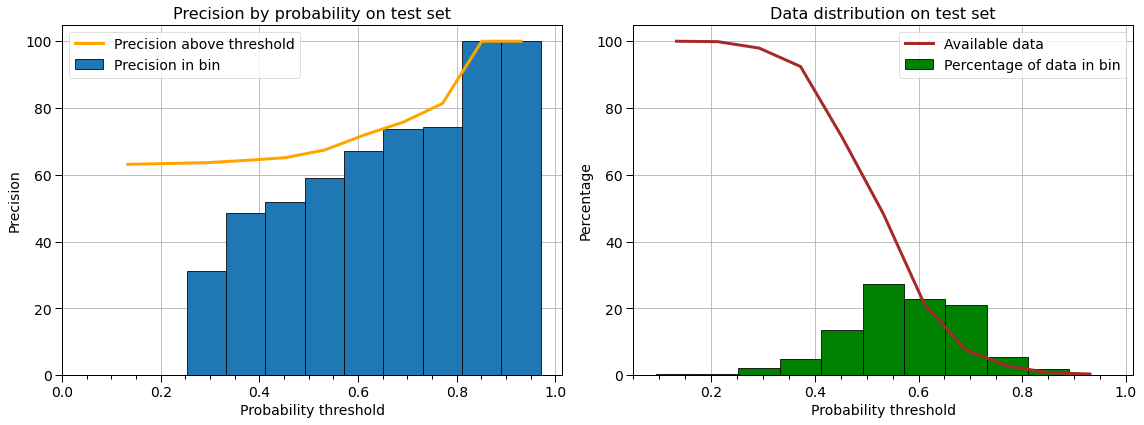

In [12]:
fontsizes = {'title': 16, 'axis': 14, 'legend': 14, 'tick': 14}

fig, axes = plt.subplots(1, 2, figsize=(16,6))

x, y_size = zip(*df_bin[['l', 'n_pct']].values)
axes[1].bar(
    x, y_size, width=0.08, edgecolor='black', 
    align='center', label='Percentage of data in bin',
    color='green'
)
y_accu_pct = df_bin['n_accumulative_pct'].values[::-1]
axes[1].plot(
    x, y_accu_pct, linewidth=3,
    color='brown', label='Available data'
)
axes[1].legend(loc='upper right', fontsize=fontsizes['legend'])
axes[1].xaxis.set_minor_locator(AutoMinorLocator())
axes[1].tick_params(which='both', width=1)
axes[1].tick_params(which='major', length=7)
axes[1].tick_params(which='minor', length=4)
axes[1].grid(True)
axes[1].set_axisbelow(True)
axes[1].set_xlabel('Probability threshold', fontsize=fontsizes['axis'])
axes[1].set_ylabel('Percentage', fontsize=fontsizes['axis'])
axes[1].set_title('Data distribution on test set', fontsize=fontsizes['title'])

x, y_bin = zip(*df_bin[['l', 'acc_in_bin']].values)
axes[0].bar(x, y_bin, width=0.08, edgecolor='black', align='center', label='Precision in bin')
axes[0].plot(df_bin.l, df_bin.acc_above, label='Precision above threshold', color='orange', linewidth=3)
axes[0].legend(loc='upper left', fontsize=fontsizes['legend'])
axes[0].xaxis.set_minor_locator(AutoMinorLocator())
axes[0].tick_params(which='both', width=1)
axes[0].tick_params(which='major', length=7)
axes[0].tick_params(which='minor', length=4)
axes[0].xaxis.set_ticks(np.arange(0, 1.1, 0.2))
axes[0].grid(True)
axes[0].set_axisbelow(True)
axes[0].set_xlabel('Probability threshold', fontsize=fontsizes['axis'])
axes[0].set_ylabel('Precision', fontsize=fontsizes['axis'])
axes[0].set_title('Precision by probability on test set', fontsize=fontsizes['title'])

for ax in axes.flatten():
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsizes['tick'])
    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsizes['tick'])

plt.tight_layout()
plt.savefig('../output/probability_thresholding.pdf')
plt.show()

For values in abstract:

In [69]:
from sklearn.metrics import precision_score
from scipy.stats import pearsonr

taus = [0.5, 0.6, 0.7]
for tau in taus:
    precision = thresholding(
        p = tau, 
        y_true=test.is_expression_successful, 
        y_score=test.y_score, 
        func=precision_score
    )
    
    print(f"Precision: P>{tau}={precision:.2f}")
    
    pearson = pearsonr(np.asarray(test.y_score > tau, dtype='int'), test.is_expression_successful.values)
    print(f"Pearson's correlation coefficient: P>{tau}={pearson[0]:.2f}")

Precision: P>0.5=0.67
Pearson's correlation coefficient: P>0.5=0.21
Precision: P>0.6=0.71
Pearson's correlation coefficient: P>0.6=0.18
Precision: P>0.7=0.77
Pearson's correlation coefficient: P>0.7=0.17


# Visualize important units in UniRep RF (Figure 3 + Figure S1)

In [13]:
unirep_rf = pickle.load(open(datadest_dir + 'UniRepRF.pkl', 'rb'))

In [14]:
seeds = np.arange(0, 10)
input_cols = unirep_rf['input_cols']

feature_imps = [unirep_rf[s]['model'].baseline_rf.best_estimator_.feature_importances_ * 100 for s in seeds]

In [15]:
seedimp = pd.DataFrame(feature_imps, columns=input_cols + 1, index=seeds+1).T
seedimp.columns.name = 'seed'
seedimp.index.name = 'UR'

In [16]:
tops = []
for x in seedimp:
    tops.append(
        seedimp[x].sort_values().tail(10)
    )

tops = pd.concat(tops, axis=1)

Load correlations dataframe

In [17]:
corrs['abs_corr'] = corrs['corr'].abs()
unit_rename = {u: u.replace('unit', 'UR') for u in ['unit_' + str(i) for i in range(1, 1901)]}
unit_cols = list(unit_rename.values())
corrs.rename(index=unit_rename, inplace=True)
corrs = corrs.reset_index().query('x != y and ms_reject == True')
corrs = corrs.loc[
    (~corrs.x.isin(unit_cols)) &
    (corrs.y.isin(unit_cols)) & 
    (~corrs.x.str.contains('Enzyme_Family')), 
].sort_values(by='abs_corr', ascending=False)

In [18]:
ur_corrs = []
for ur in ['UR_' + str(x) for x in tops.index]:
    ur_corrs.append(
        corrs.loc[corrs.y == ur, ]#.sort_values(by='abs_corr', ascending=False).head(3)
    )

ur_df = pd.concat(ur_corrs, axis=0).pivot('x', 'y', 'corr')

ur_df.columns = [x.split('_')[-1] for x in ur_df.columns]

In [21]:
def load_json(f):
    with open(f, 'r') as source:
        d = json.load(source)
    return d

node_classes=load_json('../data/node_classes.json')
node2color=load_json('../data/node2color.json')
class2nodes = defaultdict(list)
for k,v in node_classes.items():
    class2nodes[v].append(k)

## Figure 3: Heatmaps

Top: Importance of units picked in different seeds as being the 10 most important

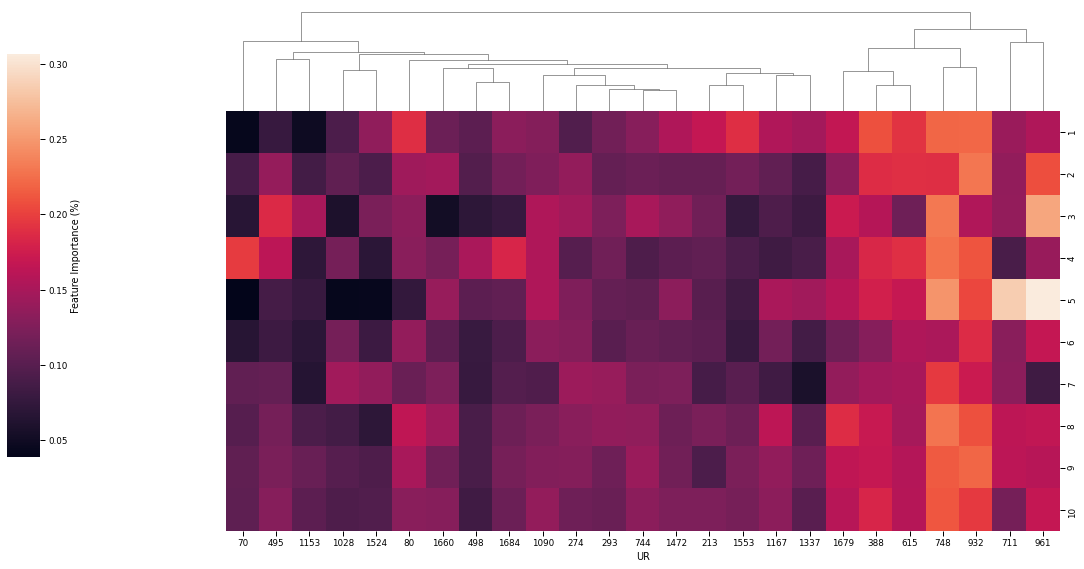

In [19]:
gcluster = sns.clustermap(
    tops.fillna(seedimp).T, 
    row_cluster=False, 
    figsize=(15,8), 
    cbar_kws={'label': 'Feature Importance (%)'}
)
gcluster.cax.set_position([0, 0.2, .03, .7]) # (left, bottom, width, height)
plt.savefig(output_dir + 'seed_imps_V_heatmap_top.pdf', bbox_inches='tight')

Bottom: Selected units and what they correlate to of sequence-based features

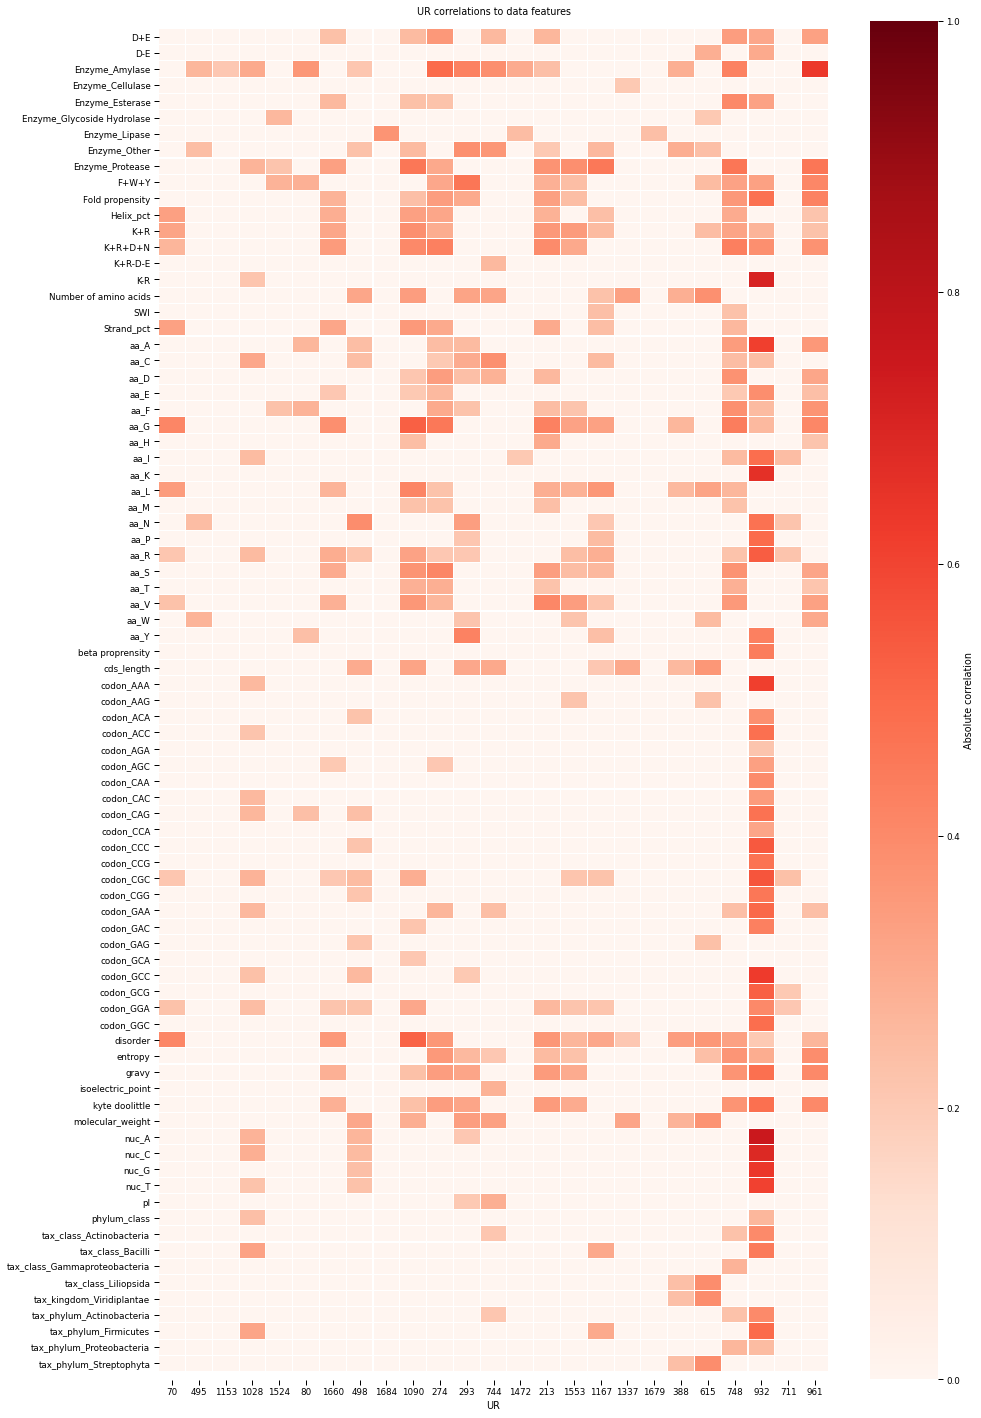

In [20]:
ylabel_order = [x.get_text() for x in g.ax_heatmap.xaxis.get_ticklabels()]
ur_df_t = ur_df.loc[:, ylabel_order].T.abs()
fig, ax2 = plt.subplots(figsize=(15,25))
sns.heatmap(
    ur_df_t.fillna(0).T,
    vmin=0, vmax=1,
    cmap='Reds',
    cbar_kws={'label': 'Absolute correlation'},
    ax=ax2,
    linewidths=.1
)
b, t = ax2.get_ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top<
ax2.set_ylim(b, t) # update the ylim(bottom, top) values
ax2.set_title('UR correlations to data features')
ax2.set_xlabel('UR')
ax2.set_ylabel('')
plt.savefig(output_dir + 'seed_imps_V_heatmap_bot.pdf', bbox_inches='tight')

In [ ]:
ur_df_t = ur_df.T.abs()
ur_df_t.index = ur_df_t.index.astype('int')
xorder= [int(t.get_text()) for t in gcluster.ax_heatmap.get_xticklabels()]
from seaborn.matrix import ClusterGrid, dendrogram, heatmap
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10,20))
gs = fig.add_gridspec(ncols=4, nrows=4, height_ratios=[.05,.4, .06, 1], width_ratios=[0.025, 1, .04, .05], hspace=0, wspace=0)

ax_top_dendrogram = fig.add_subplot(gs[0, 1:-2])

ax_top = fig.add_subplot(gs[1, 1:-2])
ax_top_cbar = fig.add_subplot(gs[1, -1])

ax_hidden = fig.add_subplot(gs[2, :])
ax_hidden.axis('off')

ax_fc = fig.add_subplot(gs[3, 0])
ax_bot = fig.add_subplot(gs[3, 1:-2], sharex=ax_top, sharey=ax_fc)
ax_bot_cbar = fig.add_subplot(gs[3, -1])


# heatmap of top units across seeds
heatmap(
    data = tops.fillna(seedimp).T[xorder],
    ax = ax_top,
    cbar_ax = ax_top_cbar,
    cbar_kws={'label': 'Feature Importance (%)'}
)

# dendgrogram at top
dendrogram(
    data = tops.fillna(seedimp).T,
    axis=1,
    ax = ax_top_dendrogram,
    label = False,
    
)


ur_df_tT = ur_df_t.T.copy().fillna(0) 
ur_df_tT['class'] = [node_classes[c] for c in ur_df_tT.index]
ur_df_tT.set_index('class', append=True, inplace=True)
ur_df_tT.drop(
    index=class2nodes['Class'] + class2nodes['Kingdom'] + class2nodes['Phylum'] + class2nodes['Codon'] + ['cds_length', 'phylum_class'], 
    errors='ignore', inplace=True)

heatmap(
    data = ur_df_tT.sort_index(level=[1, 0]).reset_index(level=1)[xorder],
    vmin=0, vmax=1,
    cmap='Reds',
    cbar_kws={'label': 'Absolute correlation'},
    ax=ax_bot,
    cbar_ax=ax_bot_cbar,
    linewidths=.1
)

# color code features
yorder = [t.get_text() for t in ax_bot.get_yticklabels()]
fcDF = pd.DataFrame({
    'node': yorder,
    'class': [node_classes[y] for y in yorder],
    'ccolor': [node2color[y] for y in yorder],
    'x': np.tile(0, len(yorder)),
    'y': np.arange(len(yorder)) + .5
})

ax_fc.scatter(fcDF['x'], fcDF['y'],c=fcDF['ccolor'], marker='s', s=500)
ax_fc.axis('off')

# label formatting
ax_top.set_xlabel('')
ax_bot.set_ylabel('')

ax_bot.set_xlabel('UR correlations to data features')
ax_bot.tick_params(axis='x', labelbottom=True, labeltop=False, bottom=True, top=True)

ax_bot.set_yticklabels([re.sub(r'(aa\_)|(Enzyme_)|(nuc_)', r'', t.get_text()).strip() + '   ' for t in ax_bot.get_yticklabels()])
ax_bot.tick_params(axis='y', labelright=False, labelleft=True, right=False, left=False)

ax_fc.tick_params(axis='y', labelright=False, labelleft=False, right=False, left=False)

ele = fcDF[['class', 'ccolor']].drop_duplicates().set_index('class').to_dict()['ccolor']
legend_handles, legend_elements = [], []
for k, v in ele.items():
    legend_elements.append(mpatches.Patch(facecolor=v, label=k))

lgd = ax_bot.legend(handles=legend_elements,loc='center left', bbox_to_anchor=(-.32, .75))
fig.subplots_adjust(left=0.02) # <-- Change the 0.02 to work for your plot.

fig.savefig('../output/figure3_v4.pdf', bbox_inches='tight')

## Figure S1 and small circos plot in Figure 1

In [22]:
corrs2 = corrs.reset_index().query('x != y and ms_reject == True')
corrs3 = corrs2.loc[(~corrs2.x.isin(unit_cols)) &(corrs2.y.isin(unit_cols)), ].sort_values(by='abs_corr', ascending=False)
corrs3 = corrs3.loc[
    (~corrs3.x.str.startswith('cds_length')) &
    (~corrs3.x.str.startswith('phylum_class')) & 
    (~corrs3.x.str.startswith('aa_X'))
]

ds_corrs = corrs3.loc[(~corrs3.x.str.startswith('Enzyme_Family')) & (~corrs3.x.str.startswith('tax_class'))]

In [23]:
featureImps = pd.DataFrame(seedimp.mean(axis=1), columns=['importance (%)'])

### Small circos in Figure 1

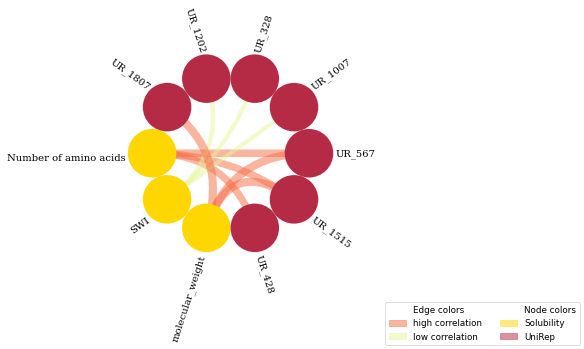

In [24]:
cool_features = ['SWI', 'molecular_weight', 'Number of amino acids']

ds_abs, node_classes2_abs = prepare_circos_data(
    corrs = ds_corrs.loc[ds_corrs.x.isin(cool_features)], 
    feature_imps = featureImps, 
    node_classes = node_classes, 
    interpret_col='abs_corr',
    top_ns=[1, 2, 3, 5, 10]
)

ds_abs[3]['size'] *= 4

g = create_circos(
    ds_abs[3],
    source='x',
    target='y',
    edge_attr=['abs_corr', 'size', 'interpretation', 'inter2', 'edge_color', 'corr_size'], 
    node_classes=node_classes2_abs,
    node_grouping='class',
    node_color='class',
    edge_width='corr_size',
    edge_color='interpretation',
    figsize=(10,4),
    title='',
    legend_label='inter2',
    legend_color='edge_color',
    node2color=node2color,
    legend_sort='interpretation',
    legend_length=1
)

#g.savefig('output/corr/circos/corr_UniRep_cool_v3.pdf')
g

### Figure S1: Large circos

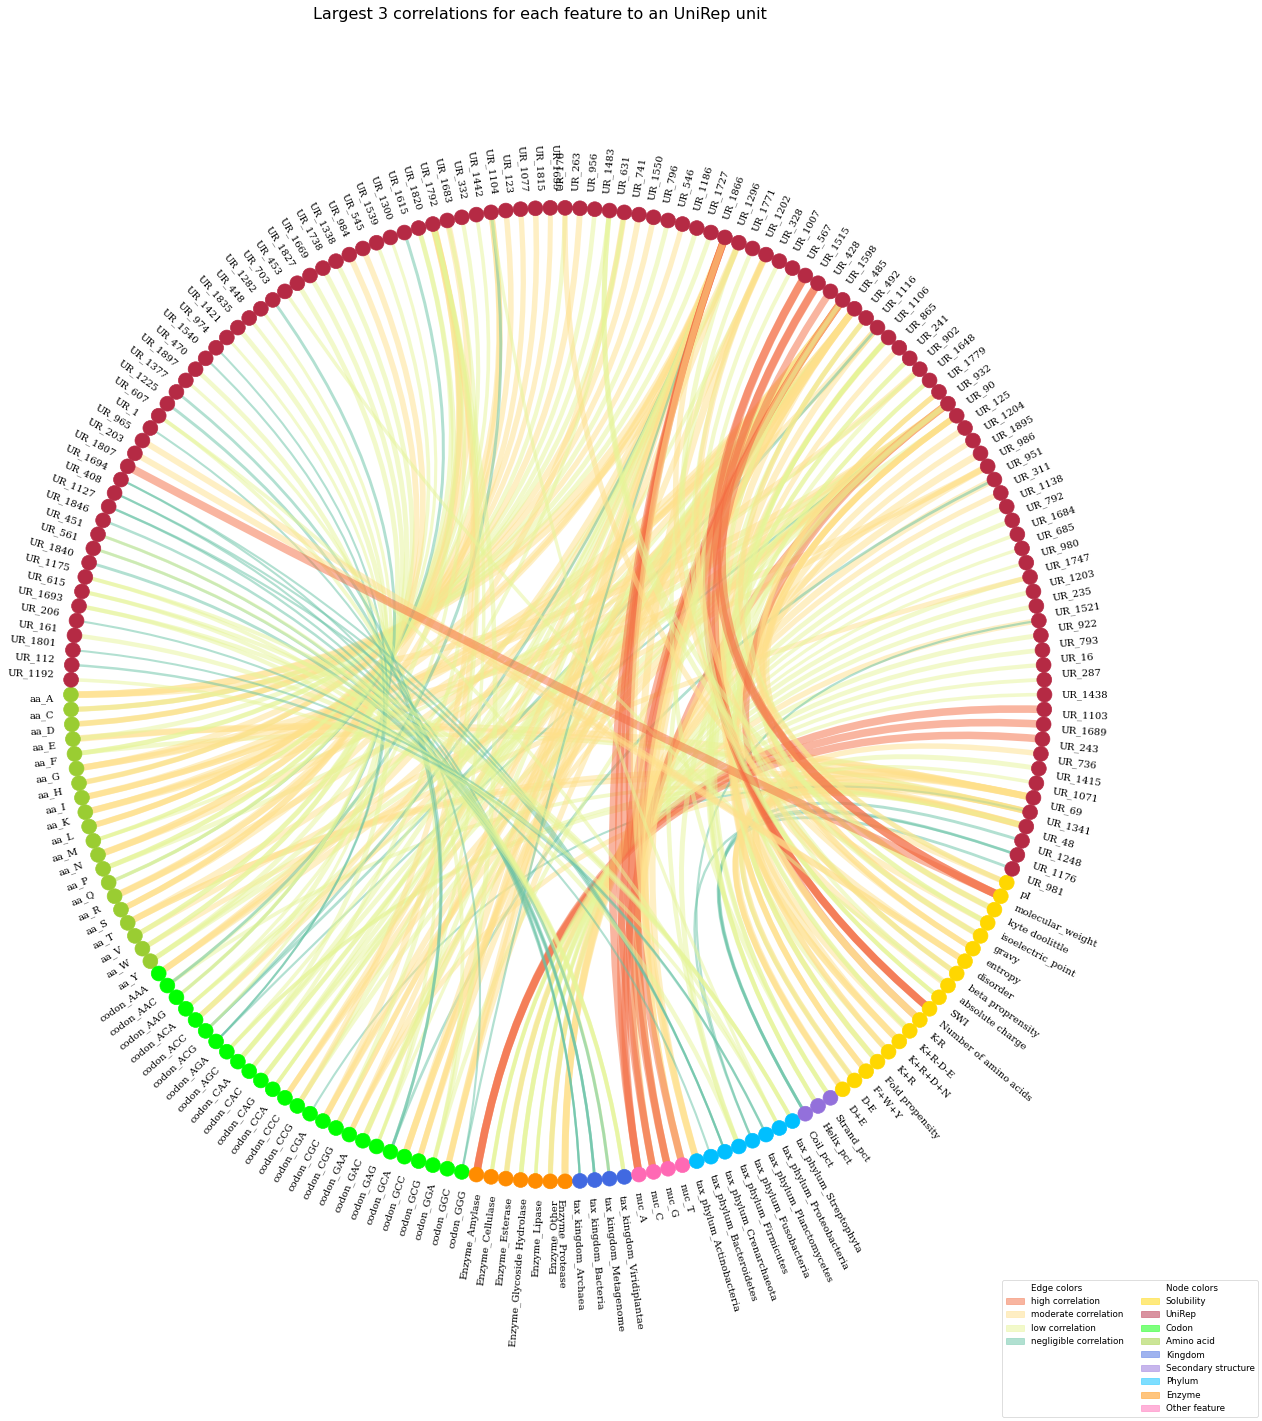

In [25]:
    k = 3

    ds_abs, node_classes2_abs = prepare_circos_data(ds_corrs, featureImps, node_classes, interpret_col='abs_corr', top_ns=[k])
    out = PdfPages(output_dir + 'corr_UniRep.pdf')

    fig = create_circos(
        ds_abs[k],
        source='x',
        target='y',
        edge_attr=['abs_corr', 'size', 'interpretation', 'inter2', 'edge_color', 'corr_size'], 
        node_classes=node_classes2_abs,
        node_grouping='class',
        node_color='class',
        edge_width='corr_size',
        edge_color='interpretation',
        figsize=(20,20),
        title='Largest {} correlation{} for each feature to an UniRep unit'.format(k, 's' if k > 1 else ''),
        legend_label='inter2',
        legend_color='edge_color',
        node2color=node2color,
        legend_sort='interpretation',
        legend_length=10
    )

    out.savefig(fig)
    out.close()

    fig